# Chapter 7 - Parameter Estimation

This notebook is based in part on the [2018 open data workshop](https://github.com/gw-odw/odw-2018).

## Bayes' Theorem: revisions

We're now going to develop a posterior function for use in Bayesian inference of source properties.  The posterior density function describes the distribution of probability (density) for all of our model parameters after observations:

$$
p(\vec{\lambda}|s) = \frac{p(\vec{\lambda})p(s|\vec{\lambda})}{p(s)},
$$

where $\vec{\lambda}$ contains all of the parameters we don't know, and $s=\{s_1, s_2, \ldots, s_{\mathrm{N}_f}\}$ are our data, in this case the strain measurements across $\mathrm{N}_f$ discrete frequency bins.

$p(\vec{\lambda})$ is the *prior*, describing our knowledge of the parameters before recording any data, e.g., we expect compact binaries' orientations to be isotropically distributed.  $p(s|\vec{\lambda})$ is the *likelihood*, which is the probability of observing the data that we've observed *if* all of the unknown parameters were to have values $\vec{\lambda}$.  Finally, $p(s)$ is the *evidence*, which for simple parameter estimation is a normalization that we can ignore, but becomes useful for model comparisons. 

To be successful in our Bayesian endeavor, we need forward models to describe (probabilistically) our observed data, i.e., signal and noise processes.  From now on we'll be making strong assumptions about the content of the data, specifically that the data consist of stationary, Gaussian noise with a known power spectral density, and a compact binary signal as described by the `SEOBNRv4` model.

## Imports

We will need some standard imports for this notebook:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

And we will need the GW-specific software `gwpy` and `pycbc`:

In [ ]:
! pip install -q gwpy

In [ ]:
! pip install -q lalsuite pycbc

In [ ]:
! pip install --upgrade -q ipykernel # needed due to matplotlib version mismatch

And restart the runtime: Runtime -> Restart runtime

## Data

As a concrete example we will continue working with the data containing **GW150914**.  Since we know *a priori* that there isn't any signal content about 1 kHz, we'll downsample the data to 2048 Hz for faster processing.  We'll also focus on the Hanford data for now.

Note that the command `TimeSeries.fetch_open_data()` downloads the data, and may take a while. It'd best to have it as a separate cell, so that you don't re-run it if you change some steps in the subsequent calculation.

In [ ]:
from gwpy.timeseries import TimeSeries

In [ ]:
time_center = 1126259462

data = TimeSeries.fetch_open_data('H1', time_center - 16, time_center + 16)

In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz
data=data.highpass(15).resample(2048)

The `TimeSeries` object do come with their own `plot()` method which takes care of the labels. It is necessary to know what the data is and how to plot it oneself, but as a shortcut to check what we are looking at, this can be useful:

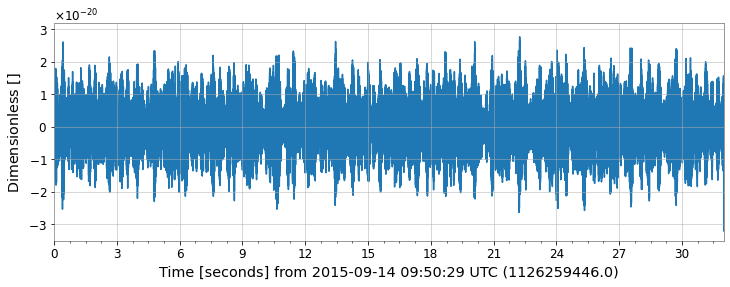

In [ ]:
data.plot();

## Likelihood

### Noise model

We know the time around **GW150914** to be well-behaved, and by that we mean stationary and Gaussian.  That means we can completely describe the (statistical) properties of the noise by the power spectral density, which we'll estimate using off-source data following the procedure in `chapter5_6.ipynb`.

In [ ]:
psd = data.psd(fftlength=4)

Text(0, 0.5, 'PSD [Hz$^{-1}$]')

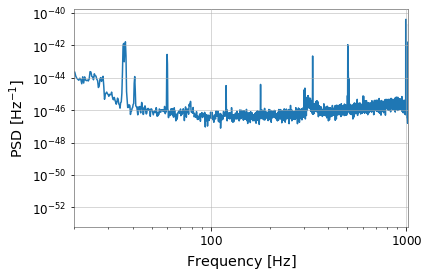

In [ ]:
psd.plot()
plt.xlim(20,1024)
plt.ylabel('PSD [Hz$^{-1}$]')

That's it.  We're going to assume that our noise is exactly described by the PSD estimated above.  In other words, we're employing a 0-parameter noise model.

For production analyses we make use of the [BayesLine](https://arxiv.org/abs/1410.3852) algorithm, which employs a parametric model for the PSD itself and allows us to work with only on-source data.

## Signal model

Here we are using the `SEOBNRv4` approximant, which describes the inspiral, merger, and ringdown phases of a binary black hole merger using a combination of analytical approximations and fits to numerical relativity simulations.

In [ ]:
from pycbc.waveform import get_td_waveform

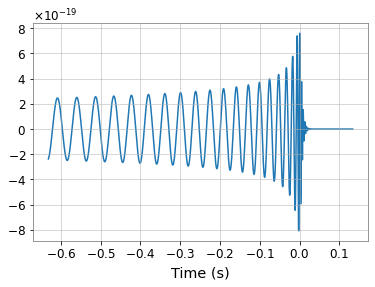

In [ ]:
m1 = 38.9 # Solar masses
m2 = 31.6 # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=data.dt.value,
                     f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

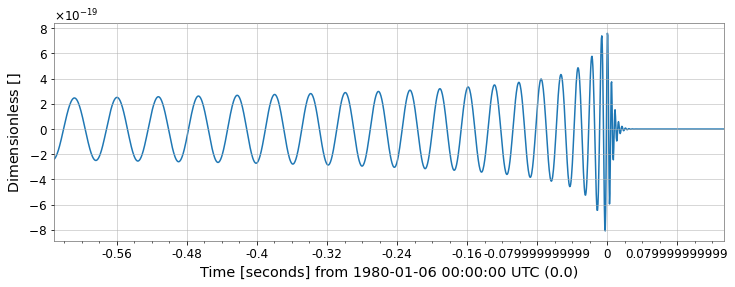

In [ ]:
TimeSeries.from_pycbc(hp).plot();

Notice that `get_td_waveform()` returns two polarizations of strain.  For now we'll just make use of the plus polarization.

For visualization (and as a proxy for what the analysis "sees" under the hood), it will be useful to look at the whitened data, where the data have been filtered to produce a flat PSD. We also remove the frequencies below 30Hz and above 300Hz, to see the signal (in general, one does now know ahead of time which frequencies are relevant, but this is useful for visualisation).

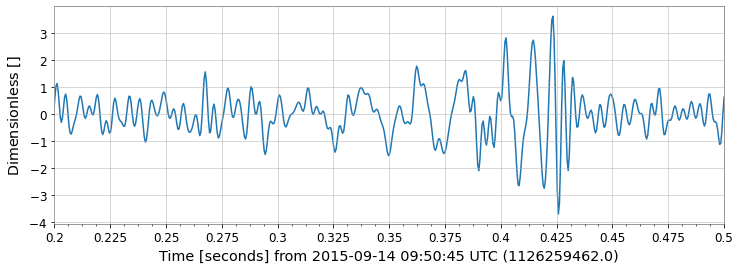

In [ ]:
white_data=data.whiten(fftlength=4).bandpass(30,300)
white_data.plot()
plt.xlim(time_center+.2, time_center+.5);

Now we'll make a light-weight wrapper for `get_td_waveform()` that will take parameter vector $\vec{\lambda}$ and generate a waveform for us with the same sampling rate and time window as our data.  For now we'll plan on varying component mass, distance, merger time, and merger phase.

Since we're only working with one detector now, we're only sensitive to one polarization, and we can't tell where on the antenna pattern our source lies.  This means we have no sensitivity to inclination, as it's entirely degenerate with distance, and that what we'll be measuring here isn't actually distance, but the distance the binary would need to be at if optimally oriented directly over-head of the detector.

In [ ]:
data=data.crop(time_center-2,time_center+2)

In [ ]:
def gen_template(param,
                 delta_t=data.dt.value,
                 duration=data.duration.value,
                 start_time=data.x0.value,
                 f_lower=20.):
    
    m1, m2, distance, time, phase = param

    h_plus, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)
    
    # Resize the signal buffer, and shift to the requested time
    h_plus.resize(int(duration/delta_t))
    h_plus = h_plus.cyclic_time_shift(h_plus.start_time + time - start_time)
    # This cyclic_time_shift does what we did in chapter 6: 
    # applying the time shift in the frequency-domain
    h_plus.start_time = start_time
    
    template=TimeSeries.from_pycbc(h_plus)

    return template

(1126259461.9, 1126259462.05)

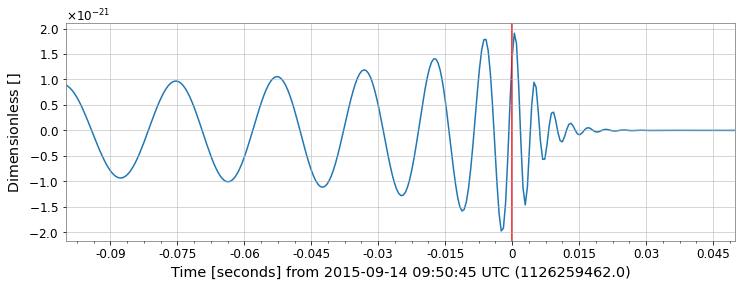

In [ ]:
param=[38.9,31.6,410.0,time_center,0.0]
template=gen_template(param)
template.plot()
plt.axvline(time_center,c='r')
plt.xlim([time_center-0.1,time_center+0.05])

## Single-detector Likelihood

With that, we're now able to define our likelihood function, which is the likelihood of observing the data we have, given particular values for all of the parameters in our model.

The probabilistic component of the data comes entirely from the noise.  So given a guess for the source parameters $\vec{\lambda}$, our likelihood is the statistical measure of the probability of the residuals (data with the model signal subtracted) having come from the noise process described by the PSD.

We will use the likelihood ratio, the ratio of the likelihood of a signal described by $\vec{\lambda}$ to the likelihood of noise only.  Since we aren't worried about normalization of the likelihood anyways we'll work in the likelihood ratio, since it has the nice feature that when maximized it should be equal to $\mathrm{SNR}^2/2$.

Since we'll be working in the frequency domain, we'll FFT the data once ahead of time.

In [ ]:
# FFT the data once, ahead of time
sf = data.average_fft(window=('tukey',1./4.))*data.duration.value/2

def loglikelihood(param, sf=sf, f_lower=20.0):
    
    # zero out the frequencies below f_lower
    sf_hp = sf.crop(start=f_lower)
    psd_hp = psd.crop(start=f_lower)
    
    template = gen_template(param, delta_t=data.dt.value ,f_lower=f_lower)
    hf = template.average_fft(window=('tukey',1./4.))*template.duration.value/2
    hf_hp = hf.crop(start=f_lower)
    
    h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
    h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)
    
    logl = h_dot_s - h_dot_h/2

    return logl.value

Now let's pick some particular values for the model parameters that we know to be in the right ballpark and generate a model signal.  We'll then whiten it and compare it to the data, and calculate the likelihood.

-1511.4063733819837


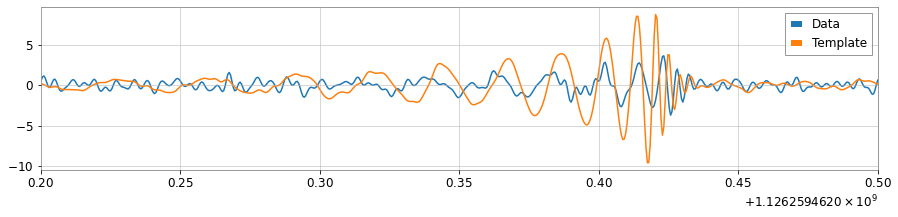

In [ ]:
# m, distance, time, phase
param0 = [38.9,31.6,410,1126259462.42,0.0]

template0 = gen_template(param0)
white_template = template0.whiten(asd=np.sqrt(psd),highpass=20.)

plt.figure(figsize=[15, 3])
plt.plot(white_data.times, white_data, label="Data")
plt.plot(white_template.times, white_template, label="Template")

plt.xlim(time_center+.2, time_center+.5)
plt.legend();

print(loglikelihood(param0))

Now let's maximize the likelihood to find the best-fit signal.  We'll use the `minimize()` function provided by scipy using the Powell method, since it's pretty good at dealing with non-smooth functions.  We'll also define a callback function to print likelihood values and plot the model as it works.

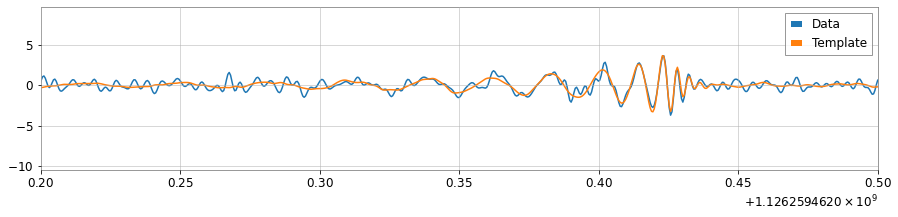

Steps	log(likelihood)
15	246.598


In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

white_template = template0.whiten(asd=np.sqrt(psd),highpass=20.)

plt.plot(white_data.times, white_data, label="Data")
line, = plt.plot(white_template.times, white_template, label="Template")
plt.xlim(time_center+.2, time_center+.5)
plt.legend()

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_template(param_i)
    white_template = template.whiten(asd=np.sqrt(psd),highpass=20.)
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()

We've now got our best-fit waveform, and it matches the data (although the fitting algorithm does fail sometimes)

In [ ]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the [Q-transform](https://en.wikipedia.org/wiki/Constant-Q_transform) to produce a high-resolution time-frequency map of the data:

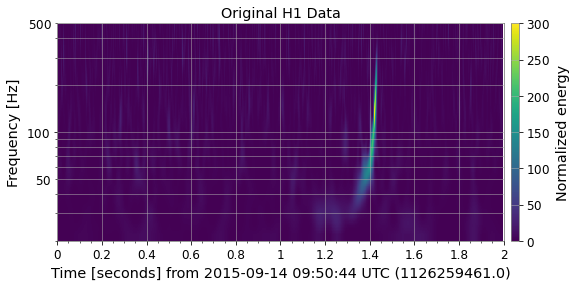

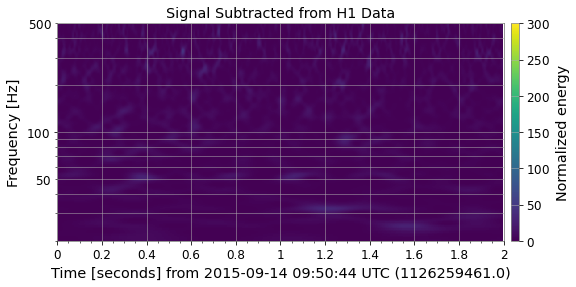

In [ ]:
subtracted = data - best_fit_template

for d, title in [(data, 'Original H1 Data'),
                 (subtracted, 'Signal Subtracted from H1 Data')]:
    
    qspecgram=d.whiten(asd=np.sqrt(psd)).q_transform(outseg=(time_center - 1, time_center + 1),
                                                     frange=(20, 512))
    
    plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
    ax = plot.gca()
    ax.set_title(title)
    ax.set_xscale('seconds')
    ax.set_yscale('log')
    ax.set_ylim(20, 500)
    ax.set_ylabel('Frequency [Hz]')
    ax.grid(True, axis='y', which='both')
    ax.colorbar(cmap='viridis', label='Normalized energy')

# **Questions**
- is the logL value sensible? Given the SNR, what is the expected logL value?
- what about priors? What could we use and how would they modify the analysis shown here?
- use the methods in this notebook to revisit CA-2 from the Data Analysis module.